### Import modules

In [4]:
%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

if sys.version_info[0] ==3:
    import pickle
else:
    import cPickle as pickle
import errno

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT

#import SRW auxiliary functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d

from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

#from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront

#Import base beamline class and OE wrappers
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import         Drift,Aperture,    Lens,Mirror_elliptical,WF_dist,calculateOPD

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

plt.ion()

### Define auxiliary functions

In [7]:
def calculate_source_fwhm(ekev, theta_fwhm):
    """
    Calculate source size from photon energy and FWHM angular divergence

    :param evev: Energy in keV
    :param theta_fwhm: theta_fwhm [units?]
    """
    wl = 12.39e-10/ekev
    k = 2 * np.sqrt(2*np.log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*np.pi*theta_sigma)
    return sigma0*k

def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011

    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    """
    Define optical path difference (OPD) from mirror profile, i.e. ill the struct opTrErMirr

    :params mdatafile: an ascii file with mirror profile data
    :params ncol: number of columns in the file
    :params delim: delimiter between numbers in an row, can be space (' '), tab '\t', etc
    :params orient: mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :params theta: incidence angle
    :params scale: scaling factor for the mirror profile
    """
    heightProfData = np.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    plt.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)')

In [8]:
def calc_sampling(zoom,mf):
    """
    This function calculates sampling.
    :param zoom: range zoom
    :param mf: modification factor for step, i.e. dx1=mf*dx0

    :return: sampling.
    """
    sampling = zoom/mf;
    print('zoom:{:.1f}; mod_factor:{:.1f}; sampling:{:.1f}'.format(zoom, mf, sampling))
    return sampling

In [9]:
def _save_object(obj, file_name):
    """
    Save any python object to file.

    :param: obj : - python objest to be saved
    :param: file_name : - output file, wil be overwrite if exists
    """
    with open(file_name,'wb') as f:
        pickle.dump(obj, f)

def _load_object(file_name):
    """
    Save any python object to file.

    :param: file_name : - output file, wil be overwrite if exists
    :return: obj : - loaded pthon object
    """
    res = None
    with open(file_name,'rb') as f:
        res = pickle.load(f)

    return res

def mkdir_p(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

def create_CRL(directory=None, voids_params=None, *args, **keywrds):
    """
    This function build CLR or load it from file if it was created beforehand.
    Out/input filename builded as sequence of function parameters.

    Adiitinal parameters (*args) passed to srwlib.srwl_opt_setup_CRL function

    :param directory: output directory to save file.
    :param voids_params: void params to build CRL and construct unique file name
    :return: SRWL CRL object
    """
    if not isinstance(voids_params,tuple):
        raise TypeError('Voids_params must be tuple')

    file_name = '_'.join([str(a) for a in args[:-1]])
    subdir_name = '_'.join([str(v) for v in voids_params])
    if directory is None:
        full_path = os.path.join(subdir_name,file_name+'.pkl')
    else:
        full_path = os.path.join(directory, subdir_name, file_name+'.pkl')

    if  os.path.isfile(full_path):
        print('Found file {}. CLR will be loaded from file'.format(full_path))
        res = _load_object(full_path)
        return res
    else:
        print('CLR file NOT found. CLR will be recalculated and saved in file {}'.format(full_path))
        res = srwlib.srwl_opt_setup_CRL(*args)
        mkdir_p(os.path.dirname(full_path))
        _save_object(res, full_path)
        return res

def create_CRL1(directory,file_name,*args, **keywrds):
    """
    This function build CLR or load it from file.
    Out/input filename builded as sequence of function parameters.
    Adiitinal parameters (*args) passed to srwlib.srwl_opt_setup_CRL function

    :param directory: output directory
    :param fiel_name: CRL file name
    :return: SRWL CRL object
    """

    full_path = os.path.join(directory, file_name+'.pkl')

    if  os.path.isfile(full_path):
        print('Found file {}. CLR will be loaded from file'.format(full_path))
        res = _load_object(full_path)
        return res
    else:
        print('CLR file NOT found. CLR will be recalculated and saved in file {}'.format(full_path))
        res = srwl_opt_setup_CRL(*args)
        mkdir_p(os.path.dirname(full_path))
        _save_object(res, full_path)
        return res

### Defining initial wavefront and writing electric field data to h5-file

1. define distance to CRL1/2 and mirror1/2 on SASE 1/2
2. define beam parameter
3. calculate beam fwhm for grid size (7 x fwhm)
4. build gaussian wavefront using beam parameters at targeted plane
5. get horizontal and vertical lineout of the beam intensity (power)

*****defining initial wavefront and writing electric field data to h5-file...
sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.499788231945866, 27.079931842197144,2.9970290603902483
save hdf5: g6_742kev.h5
done
FWHMx [mm]: 0.7006724761476186
FWHMy [mm]: 0.7006724761476186
Coordinates of center, [mm]: -0.002097821784873173 -0.002097821784873173
stepX, stepY [um]: 4.1956435697462195 4.1956435697462195 

Total power (integrated over full range): 54.4346 [GW]
Peak power calculated using FWHM:         54.0769 [GW]
Max irradiance: 96.8138 [GW/mm^2]
R-space
FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: 0.7006724761476186, 2.9815850048834838


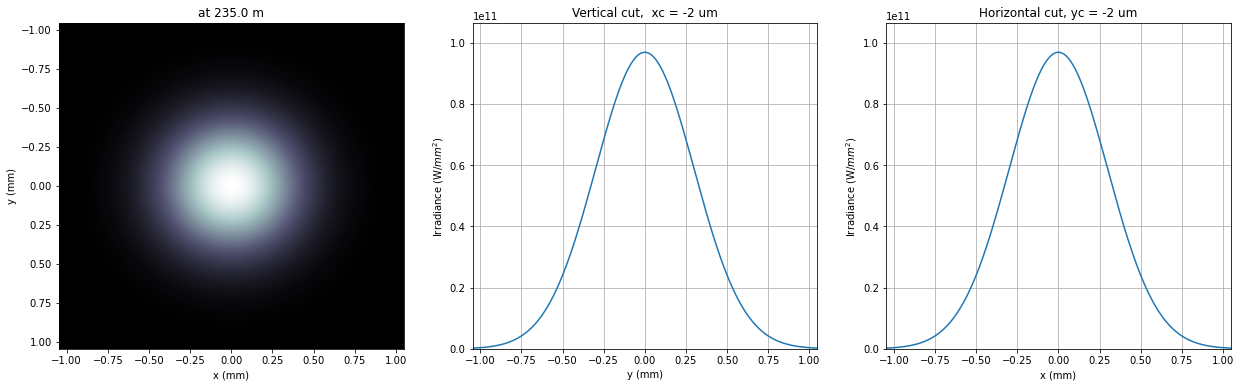

In [150]:
print('*****defining initial wavefront and writing electric field data to h5-file...')

strInputDataFolder ='data_common' # sub-folder name for common input  data
strDataFolderName = 'Tutorial_case_1' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

d2crl1_sase1 = 235.0 # Distance to CRL1 on SASE1 [m]
d2crl1_sase2 = 235.0 # Distance to CRL1 on SASE2 [m]
d2m1_sase1 = 246.5  # Distance to mirror1 on SASE1 [m]
d2m1_sase2 = 290.0  # Distance to mirror1 on SASE2 [m]

ekev = 6.742 # Energy [keV]
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
pulse_duration = 9.e-15;
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = 0.24e-15


d2m1 = d2m1_sase2
d2crl1 = d2crl1_sase2

z1 = d2crl1
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('sigX, waist_fwhm [um], far field theta_fwhms [urad]: {}, {},{}'.format(
                            sigX*1e6, sigX*k*1e6, theta_fwhm*1e6)
      )
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
npoints=500

wfr0 = build_gauss_wavefront_xy(npoints, npoints, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,sigX, sigX, z1,
                                pulseEn=pulseEnergy, pulseTau=coh_time/np.sqrt(2),
                                repRate=1/(np.sqrt(2)*pulse_duration))

mwf = Wavefront(wfr0)
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
ename = str(int(ip))+'_'+str(int(frac))+'kev'
fname0 = 'g' + ename
ifname = os.path.join(strDataFolderName,fname0+'.h5')
print('save hdf5: '+fname0+'.h5')
mwf.store_hdf5(ifname)
print('done')
pow_x=plot_wfront(mwf, 'at '+str(z1)+' m',False, False, 1e-5,1e-5,'x', True, saveDir='./'+strDataFolderName)
plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf);fwhm_y = calculate_fwhm_y(mwf)
print('FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: {}, {}'.format(
        fwhm_x*1e3,fwhm_x/z1*1e6)
      )

In [151]:
print(pow_x[:,1].max())
print ('I_o {} [GW/mm^2]'.format((pow_x[:,1].max()*1e-9)))
print ('peak power {} [GW]'.format((pow_x[:,1].max()*1e-9*1e6*2*np.pi*(fwhm_x/2.35)**2)))

96813826048.0
I_o 96.81382604800001 [GW/mm^2]
peak power 54.0768820398055 [GW]


### Defining optical beamline(s) 

Text(0.5, 1.0, 'Amplitude Transmission')

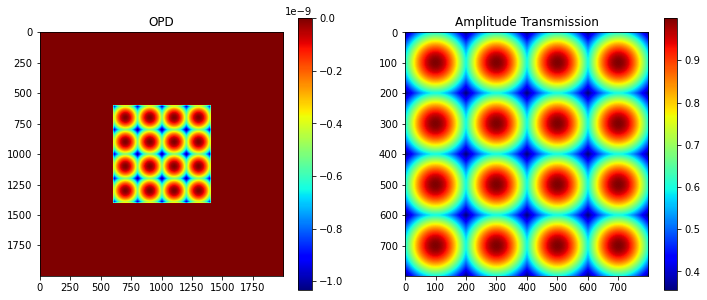

In [215]:
# OE thickness functions
def Perfect_lens(x,y,n,f,xoff=0,yoff=0):
    delta_d = f - np.sqrt(f**2-np.square(x-xoff)-np.square(y-yoff))
    z = -delta_d/(n-1)
    return z

def Perfect_lens_array(x,y,n,f,nlx,nly):
    nx,ny = x.shape
    z = np.zeros((nx,ny))
    npts = int(nx/nlx)
    dl = (x.max()-x.min())/(nx-1) * npts
    if npts != nx/nlx:
        print('need integer multiples of small lens dimension')
    else:
        for il in range(nlx):
            xi = il * npts
            xf = (il+1)*npts
            for jl in range(nly):
                yi = jl * npts
                yf = (jl+1)*npts
                xl = x[xi:xf,yi:yf]
                yl = y[xi:xf,yi:yf]
                xlcent = xl.mean()
                ylcent = yl.mean()
                z[xi:xf,yi:yf] = Perfect_lens(xl,yl,n,f,xlcent,ylcent)
    return z

#def Double_slit(x,y,d,w1,w2,orientation):
    

# function to calculate optical path differnece and amplitude transmission
def Calc_OPD_and_AmpTr(srwTr, thicknessProfData, n, d_abs):
    N = len(thicknessProfData[0])
    auxMesh = srwTr.mesh
    nx = auxMesh.nx
    ny = auxMesh.ny
    if thicknessProfData.shape==(nx,ny):
        # amplitude transmission
        Tr = np.exp(-thicknessProfData/d_abs)
        # OPD
        OPD = thicknessProfData*(n-1)
        #for iy in range(ny):
        #    for ix in range(nx):
        for iy in (np.arange(800)+600):
            for ix in (np.arange(800)+600):
                        ofst = 2*ix + 2*nx*iy
                        srwTr.arTr[ofst]=Tr[ix,iy]
                        srwTr.arTr[ofst+1]=OPD[ix,iy]
    else:
        print('OE shape not matched')

# OE
E = ekev*1000
OE_width = 0.5e-3      # physical size of OE aperture
nx = 2000; ny = 2000   # number of points in H and V
nlx = int(OE_width/(50e-6)); nly = nlx     # number of micro lenses in an array
if nlx != OE_width/50e-6:
    print('need integer number of micro lens')

n = 0.99999            # refractive index
d_abs = 100e-6        # absorption depth
f = 0.6

OE_Apt = SRWLOptA('r','a',OE_width,OE_width)
OE_Tr = SRWLOptT(nx,ny,OE_width,OE_width,_Fx=f,_Fy=f,_x=0,_y=0,_eStart=E,_eFin=E)
#OE_Tr = SRWLOptT(nx,ny,OE_width,OE_width,_x=0,_y=0,_eStart=E,_eFin=E)

OE_x = np.linspace(-OE_width/2,OE_width/2,nx)
OE_y = np.linspace(-OE_width/2,OE_width/2,ny)
OE_x, OE_y = np.meshgrid(OE_x,OE_y)

#OE_z = Perfect_lens(OE_x,OE_y,n,f)
OE_z = Perfect_lens_array(OE_x,OE_y,n,f,nlx,nly)
Calc_OPD_and_AmpTr(OE_Tr, OE_z, n,d_abs)


OPD_show = np.array(OE_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(OE_Tr.arTr)[0::2].reshape(ny,nx)


Text(0.5, 1.0, 'Amplitude Transmission')

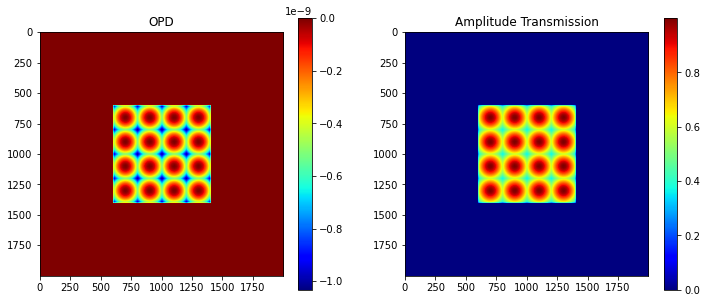

In [216]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(OPD_show,cmap='jet')
plt.title('OPD')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(AmpTr_show[600:1400,600:1400],cmap='jet')
plt.imshow(AmpTr_show,cmap='jet')
plt.colorbar()
plt.title('Amplitude Transmission')


In [212]:
print('*****Defining optical beamline(s) ...')

z2 = f

optBL0 = Beamline()
opCRL1 = OE_Tr
#optBL0.append(Aperture(shape='c',ap_or_ob='a',Dx=range_xy), Use_PP())# circular CRL aperture
optBL0.append(OE_Apt,    Use_PP())
optBL0.append(opCRL1,     Use_PP())
optBL0.append(Drift(z2), Use_PP(semi_analytical_treatment=1))


*****Defining optical beamline(s) ...


### Propagating through BL0 beamline. Collimating CRL and ideal mirror

*****Collimating CRL and ideal mirror
*****setting-up optical elements, beamline:bl0
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 0.6
	Fy = 0.6
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.00025
		xStart = -0.00025
		yFin = 0.00025
		yStart = -0.00025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.6
	treat = 0
	

save hdf5:Tutorial_case_1\g6_742kev_bl0.h5
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape

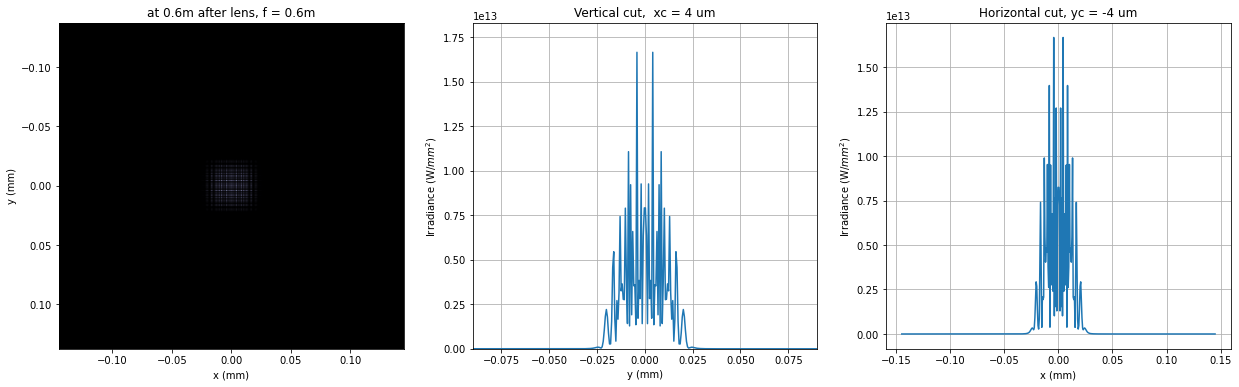

In [213]:
print('*****Collimating CRL and ideal mirror')
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
optBL = optBL0
strBL = 'bl0'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:'+ strBL)

if not NEW_SYNTAX:
    bl = Beamline(optBL)
else:
    bl = optBL
print(bl)

if bSaved:
    out_file_name = os.path.join(strDataFolderName, fname0+'_'+strBL+'.h5')
    print('save hdf5:'+ out_file_name)
else:
    out_file_name = None

startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

# plot
print('*****focusing')
plot_wfront(mwf, 'at '+str(z2)+'m after lens, f = {}m'.format(f),False, False, 1e-4,1e-7,'x', True, saveDir='./'+strDataFolderName)
plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
plt.axis('tight')
print('FWHMx [mm], theta_fwhm [urad]: {}, {}'.format(calculate_fwhm_x(mwf)*1e3, calculate_fwhm_x(mwf)/(z1+z2)*1e6))
print('FWHMy [mm], theta_fwhm [urad]: {}, {}'.format(calculate_fwhm_y(mwf)*1e3, calculate_fwhm_y(mwf)/(z1+z2)*1e6))

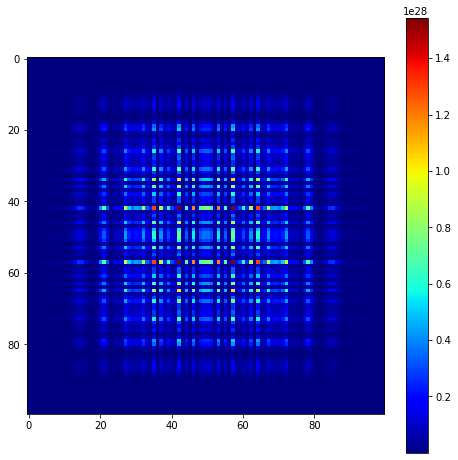

In [214]:
plt.figure(figsize=(8,8))
plt.imshow(mwf.get_intensity(slice_number=0)[200:300,200:300],cmap='jet')
plt.colorbar()